Linear regression is a supervised machine learning technique that dates back to at least the 19th century. It remains a cornerstone of modern data analysis, generating a linear model that predicts the values of a dependent variable based on one or more independent variables. This notebook introduces an alternative approach to traditional linear regression, employing linear optimization to optimize based on the Least Absolute Deviation (LAD) metric.

Unlike standard techniques that aim to minimize the sum of squared errors, this LAD-based method focuses on minimizing the sum of absolute differences between observed and estimated values. This corresponds to considering the 
 norm of the errors, which is known for its robustness against outliers.

# Generate the data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression

n_features = 1
n_samples = 1000
noise = 30

np.random.seed(2021)
X,y = make_regression(n_samples=n_samples, n_features=n_features, noise=noise)

# visualization

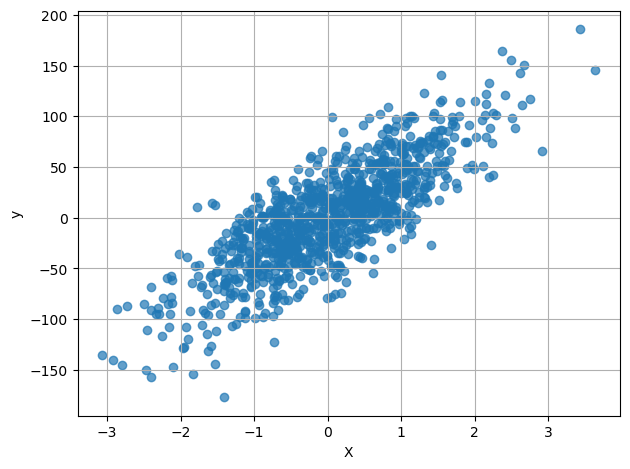

In [6]:
fig,ax = plt.subplots()
ax.scatter(X,y,alpha = 0.7)
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.grid(True)
plt.tight_layout()
plt.show()

In [8]:
solver = 'appsi_highs'
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)


In [10]:

def lad_regression(X,y):
    model = pyo.ConcreteModel('LAD_Regression')

    # get the diamesions of data
    n, k = X.shape
    
    # create index sets
    model.I = pyo.RangeSet(0, n-1)
    model.J = pyo.RangeSet(0, k-1)

    # create variables
    model.ep = pyo.Var(model.I, domain = pyo.NonNegativeReals)
    model.em = pyo.Var(model.I, domain = pyo.NonNegativeReals)
    model.m = pyo.Var(model.J)
    model.b = pyo.Var()

    # Constraints
    @model.Constraint(model.I)
    def residuals(model,i):
        return model.ep[i] - model.em[i] == y[i] - sum(X[i][j] * model.m[j] for j in model.J)-model.b

    @model.Objective(sense = pyo.minimize)
    def sum_of_abs_errors(model):
        return pyo.quicksum(model.ep[i]+model.em[i] for i in model.I)

    SOLVER.solve(model)
    return model

model = lad_regression(X, y)
print(
    f"Optimal solution: m = {[f'{model.m[j].value:.2f}' for j in model.J][0]} and b = {model.b.value:.2f}"
)
print(f"Objective value: {pyo.value(model.sum_of_abs_errors):.2f}")


Optimal solution: m = 39.66 and b = 1.14
Objective value: 24276.10


# Linear Regression

 In multiple linear regression, the goal is to minimize the sum of squared errors (SSE) rather than the sum of absolute errors. Additionally, the error terms $ e_i $ are typically not constrained to be non-negative.


**Objective:**

$$ \text{Minimize} \quad \frac{1}{N} \sum_{i=1}^{N} e_i^2 $$

**Subject to:** 

$$ e_i = y_i - m^T X_i - b \quad \forall i \in \{1, 2, ..., N\} $$
$$e_i \geq 0 \quad \forall i \in \{1, 2, ..., N\}$$
$$m \in R \quad \forall j \in \{1, 2, ..., K\}$$
$$b \in R $$

In [ ]:
# highs does not handle quadratic expression therefore we use gurobi

In [46]:
n_features = 2
n_samples = 1000
noise = 30

np.random.seed(2021)
X,y = make_regression(n_samples=n_samples, n_features=n_features, noise=noise)

In [30]:
import pyomo.environ as pyo
import numpy as np

def LinRegression(X, y):
    model = pyo.ConcreteModel('Linear_Regression')

    N, K = X.shape
    # create sets
    model.I = pyo.RangeSet(0, N-1)
    model.J = pyo.RangeSet(0, K-1)

    # decision variables
    model.e_i = pyo.Var(model.I, domain=pyo.Reals)  # Allow negative residuals
    model.m_j = pyo.Var(model.J, domain=pyo.Reals)
    model.b = pyo.Var(domain=pyo.Reals)

    # Objective function
    @model.Objective(sense=pyo.minimize)
    def sum_of_squared_residuals(model):
        return sum(model.e_i[i]**2 for i in model.I)

    @model.Constraint(model.I)
    def residual(model, i):
        return model.e_i[i] == y[i] - sum(X[i, j]*model.m_j[j] for j in model.J) - model.b
    
    # Solve the model
    solver = pyo.SolverFactory('gurobi')
    results = solver.solve(model)

    # Check if the solver found an optimal solution
    if results.solver.status == pyo.SolverStatus.ok and results.solver.termination_condition == pyo.TerminationCondition.optimal:
        return model
    else:
        raise ValueError("Solver did not find an optimal solution")


model = LinRegression(X, y)

# Extract coefficients and intercept
coefficients = [pyo.value(model.m_j[j]) for j in model.J]
intercept = pyo.value(model.b)

print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")
print(f"Mean Squared Error: {pyo.value(model.sum_of_squared_residuals) / len(y):.4f}")


Coefficients: [76.44340213934595, 73.7369907548132]
Intercept: 0.18719098970786177
Mean Squared Error: 881.9895


## verify with Sklearn

In [32]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)
print(f"Coefficients: {lr.coef_}")
print(f"Intercept: {lr.intercept_}")

Coefficients: [76.44340214 73.73699075]
Intercept: 0.18719098970786074


# Using OOPS

In [48]:
import numpy as np

class LinRegressor(pyo.ConcreteModel):
    
    def __init__(self, X, y): 
        super().__init__()
        self.X = np.array(X)
        self.y = np.array(y)
        self.Coef_ = []
        self.Intercept_ = []
        self.solved = False
        
    def build_model(self):
        model = self
        
        # Create sets
        model.I = pyo.RangeSet(0, self.X.shape[0] - 1)  
        model.J = pyo.RangeSet(0, self.X.shape[1] - 1)  

        # Decision variables
        model.e = pyo.Var(model.I, domain=pyo.Reals)  
        model.m = pyo.Var(model.J, domain=pyo.Reals)
        model.b = pyo.Var(domain=pyo.Reals)
    
        # Objective function: Minimize sum of squared residuals
        @model.Objective(sense=pyo.minimize)
        def sum_of_squared_residuals(model):
            return sum(model.e[i]**2 for i in model.I)
    
        # Constraints: residuals definition
        @model.Constraint(model.I)
        def residual(model, i):
            return model.e[i] == self.y[i] - sum(self.X[i, j] * model.m[j] for j in model.J) - model.b

    def optimize(self):
        self.build_model()
        
        # Solve the model using Gurobi
        solver = pyo.SolverFactory('gurobi')
        results = solver.solve(self)

        # Check if the solution is optimal
        if results.solver.status == pyo.SolverStatus.ok and results.solver.termination_condition == pyo.TerminationCondition.optimal:
            self.solved = True
            return True
        else:
            raise ValueError("Solver did not find an optimal solution")

    def result(self):
        if not self.solved:
            raise ValueError("The model has not been solved yet.")
        
        # Extract coefficients and intercept
        coefficients = [pyo.value(self.m[j]) for j in self.J]
        intercept = pyo.value(self.b)
        
        return coefficients, intercept


model = LinRegressor(X, y)
if model.optimize():
    coefficients, intercept = model.result()
    print(f"Coefficients: {coefficients}")
    print(f"Intercept: {intercept}")


Coefficients: [76.44340213934595, 73.7369907548132]
Intercept: 0.18719098970786177


## Thank You